# Fine Tuning Sub-Testing Results




# Imports

In [1]:
!pip install transformers datasets scikit-learn pandas numpy tqdm tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset # Hugging Face
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

# Loading Distilbert & Tokenizer

In [2]:
# Load the "all agree" subset
dataset = load_dataset("financial_phrasebank", "sentences_allagree") # All agree signifies 100% of annotators agreed on sentiment of this subset

# Load tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Balanced Weights (Benchmark)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
227/227 [==============================] - 32s 92ms/step - loss: 0.5487 - accuracy: 0.7576 - val_loss: 0.4185 - val_accuracy: 0.7965
Epoch 2/3
227/227 [==============================] - 19s 86ms/step - loss: 0.4093 - accuracy: 0.8100 - val_loss: 0.5103 - val_accuracy: 0.8009
Epoch 3/3
29/29 [==============================] - 2s 60ms/step - loss: 0.3195 - accuracy: 0.8855
Test Loss: 0.3195, Test Accuracy: 0.8855


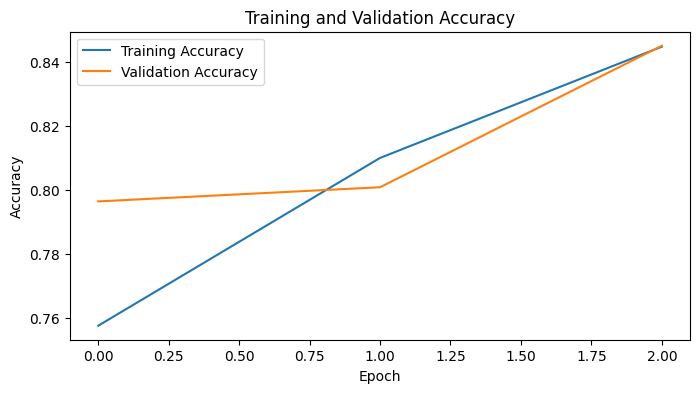

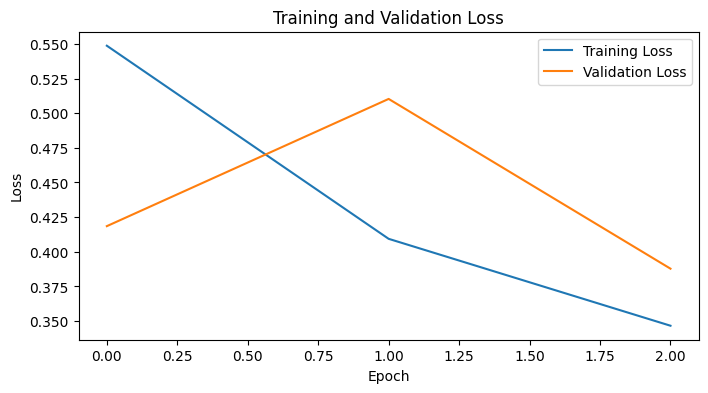

29/29 [==============================] - 3s 59ms/step
              precision    recall  f1-score   support

    Negative       0.84      0.70      0.76        30
     Neutral       0.94      0.96      0.95       142
    Positive       0.77      0.78      0.77        55

    accuracy                           0.89       227
   macro avg       0.85      0.82      0.83       227
weighted avg       0.88      0.89      0.88       227

[[ 21   1   8]
 [  0 137   5]
 [  4   8  43]]


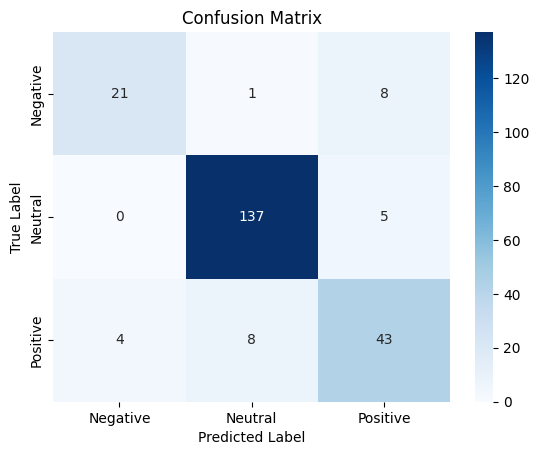

In [3]:
# Tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow dataset
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze DistilBERT encoder
model.distilbert.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training & validation accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Soft Scaled Balanced Weights

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Softened Class Weights: {0: np.float64(1.8123188405797102), 1: np.float64(0.7716771677167718), 2: np.float64(1.1421985815602835)}
Epoch 1/3
227/227 [==============================] - 28s 93ms/step - loss: 0.6535 - accuracy: 0.7515 - val_loss: 0.4309 - val_accuracy: 0.8097
Epoch 2/3
227/227 [==============================] - 20s 87ms/step - loss: 0.4708 - accuracy: 0.8266 - val_loss: 0.3862 - val_accuracy: 0.8540
Epoch 3/3
29/29 [==============================] - 2s 61ms/step - loss: 0.3673 - accuracy: 0.8502
Test Loss: 0.3673, Test Accuracy: 0.8502


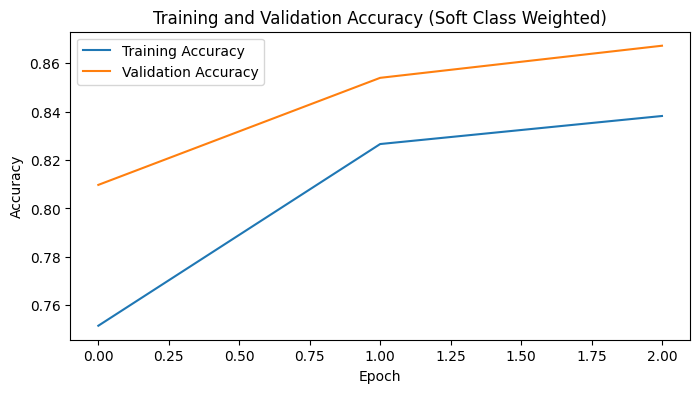

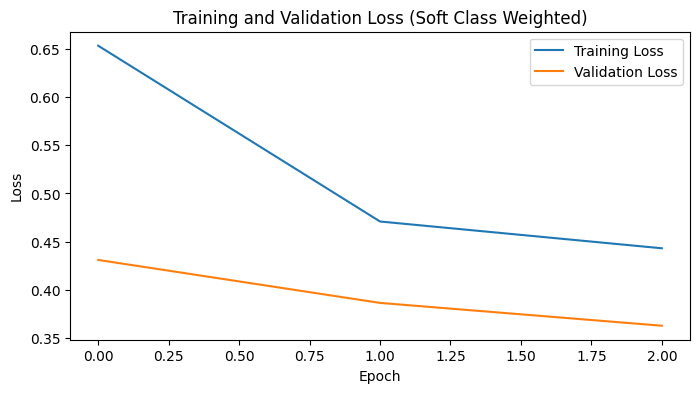

29/29 [==============================] - 3s 59ms/step
              precision    recall  f1-score   support

    Negative       0.58      0.87      0.69        30
     Neutral       0.96      0.95      0.96       142
    Positive       0.76      0.58      0.66        55

    accuracy                           0.85       227
   macro avg       0.77      0.80      0.77       227
weighted avg       0.86      0.85      0.85       227



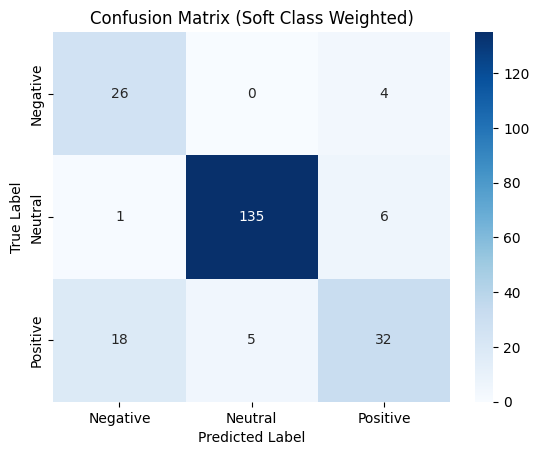

In [4]:
# Tokenization (same as before)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (same)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets
tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False

# Calculate softened class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = np.array(train_val_split['train']['label'])
balanced_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Soft scaling factor (e.g., 0.5 to moderate the imbalance correction)
scaling_factor = 0.5
soft_class_weight_dict = {i: 1 + (balanced_class_weights[i] - 1) * scaling_factor for i in range(3)}

print("Softened Class Weights:", soft_class_weight_dict)

# Compile model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train (using softened class weights)
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3,
    class_weight=soft_class_weight_dict
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Soft Class Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Soft Class Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix (Soft Class Weighted)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Custom Weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Custom Class Weights: {0: 1.8, 1: 1.0, 2: 1.3}
Epoch 1/3
227/227 [==============================] - 27s 93ms/step - loss: 0.7367 - accuracy: 0.7477 - val_loss: 0.4397 - val_accuracy: 0.8009
Epoch 2/3
227/227 [==============================] - 20s 87ms/step - loss: 0.5403 - accuracy: 0.8250 - val_loss: 0.4633 - val_accuracy: 0.8407
Epoch 3/3
29/29 [==============================] - 2s 60ms/step - loss: 0.3467 - accuracy: 0.8414
Test Loss: 0.3467, Test Accuracy: 0.8414


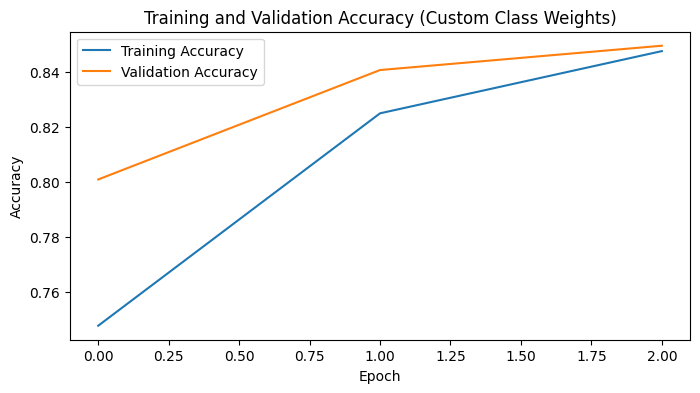

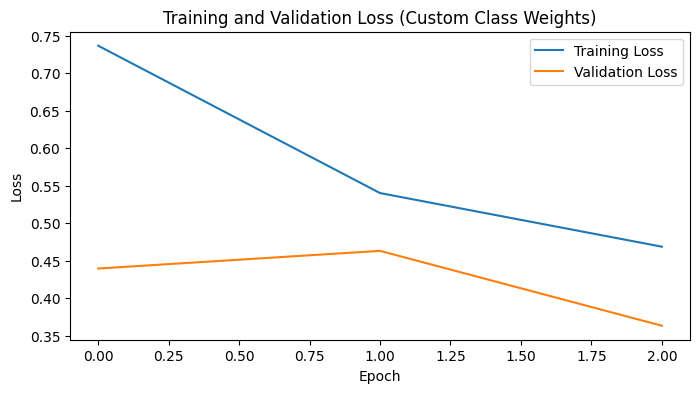

29/29 [==============================] - 3s 59ms/step
              precision    recall  f1-score   support

    Negative       0.56      0.80      0.66        30
     Neutral       0.96      0.96      0.96       142
    Positive       0.73      0.55      0.62        55

    accuracy                           0.84       227
   macro avg       0.75      0.77      0.75       227
weighted avg       0.85      0.84      0.84       227



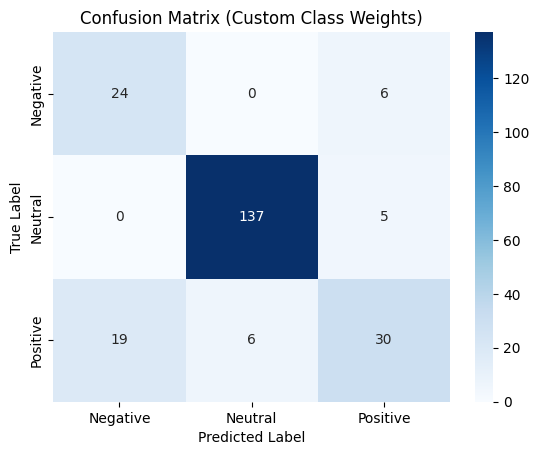

In [5]:
# Tokenization (same as before)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (same)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets
tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False

# Define custom class weights based on EDA inference
custom_class_weight_dict = {
    0: 1.8,  # Negative
    1: 1.0,  # Neutral
    2: 1.3   # Positive
}

print("Custom Class Weights:", custom_class_weight_dict)

# Compile model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3,
    class_weight=custom_class_weight_dict
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Custom Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Custom Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix (Custom Class Weights)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
